In [1]:
import pandas as pd
import numpy as np
import os
import sys
from copy import copy
from scipy.spatial import Delaunay, ConvexHull
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from scipy.spatial.distance import euclidean
import itertools
from collections import Counter

data_path = '../data/RESULTS_EUROVIS2015.csv'
folder_path = "../data/EUROVIS_new/"

os.getcwd()



'/Users/morarica/Developer/SepMe/Jupyters'

In [2]:
df = pd.read_csv(data_path)
#print(df.head())

for i, file in enumerate(df.fileName):
    file_name = folder_path + file.split('.csv')[0] + '_cls' + str(df.classNum[i]) + '.csv'
    try:
        sample_df = pd.read_csv(file_name, names=['x','y','class'])
        #print(sample_df.head(1))
    except FileNotFoundError:
        print('File \'' + file +'\' does not exist.')

sample_df.head()

File 'AUCBA' does not exist.


,x,y,class
0,121,289,0
1,129,223,0
2,130,257,0
3,135,191,0
4,138,315,0


In [3]:
df.tail()

,fileName,indexFile,indexDR,classNum,scoreA,scoreM,scoreDes,DSC,CAL,HM,...,DC 20%,HDM 80,DC 2%,DUNN,DC 1%,DC 0.5%,CDM 1,DC 0.2%,DC 0.1%,AWTN
824,worldmap_TSNE.csv,70,4,9,5,5,1,84.895833,21.835939,92.033352,...,80.796834,100.000000,99.946928,0.033704,100.000000,100.000000,96.169718,100.000000,100.000000,368.798170
825,worldmap_TSNE.csv,70,4,10,5,5,1,96.875000,96.551872,90.696429,...,80.912010,100.000000,99.991774,0.039895,100.000000,100.000000,95.410568,100.000000,100.000000,318.850108
826,worldmap_TSNE.csv,70,4,11,5,5,1,51.041667,0.789124,91.362224,...,85.076276,100.000000,99.993101,0.038154,100.000000,100.000000,95.814333,100.000000,100.000000,384.181980
827,worldmap_TSNE.csv,70,4,12,5,5,1,68.750000,0.506133,92.340861,...,91.992379,100.000000,99.993366,0.037455,100.000000,100.000000,92.358426,100.000000,100.000000,380.547726
828,AUCBA,0,0,0,0,0,0,0.825445,0.812012,0.811283,...,0.655484,0.655272,0.640985,0.632263,0.625403,0.621176,0.617904,0.604139,0.563681,0.524822


In [4]:
df = sample_df
def attr_difference(G, H):
    """Returns a new graph that contains the edges with attributes that exist in G but not in H.

    The node sets of H and G must be the same.

    Parameters
    ----------
    G,H : graph
       A NetworkX graph.  G and H must have the same node sets.

    Returns
    -------
    D : A new graph with the same type as G.
    """
    # create new graph
    if not G.is_multigraph() == H.is_multigraph():
        raise nx.NetworkXError('G and H must both be graphs or multigraphs.')
    R = nx.create_empty_copy(G)

    if set(G) != set(H):
        raise nx.NetworkXError("Node sets of graphs not equal")

    if G.is_multigraph():
        edges = G.edges(keys=True)
    else:
        edges = G.edges(data = True)
        #print(edges)
    for e in edges:
        if not H.has_edge(*e[:2]):
            #print(e)
            R.add_edge(*e[:2], weight = e[2]['weight'])
    return R


def add_node_attr(graph, df):
    # add node position and class as attributes
    for n in graph.nodes():
        graph.node[n]['pos'] = list(df.loc[n,['x','y']])
        graph.node[n]['class'] = int(df.loc[n,['class']])
    return graph

def get_delaunay(df, with_tri = False):
    graph = nx.Graph()
    tri = Delaunay(df[['x','y']])

    edges = set()
    for n in range(tri.nsimplex):
        edge = sorted([tri.simplices[n,0], tri.simplices[n,1]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,0],['x','y']]), (df.loc[tri.simplices[n,1],['x','y']]))))
        edge = sorted([tri.simplices[n,0], tri.simplices[n,2]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,0],['x','y']]), (df.loc[tri.simplices[n,2],['x','y']]))))
        edge = sorted([tri.simplices[n,1], tri.simplices[n,2]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,1],['x','y']]), (df.loc[tri.simplices[n,2],['x','y']]))))

    graph.add_weighted_edges_from(edges)

    if with_tri:
        tri.close()
        return graph, tri
    
    return graph

def get_convex_hull(df):
    graph = nx.Graph()
    hull = ConvexHull(df[['x','y']])
    
    weighted_edges = []
    for edge in hull.simplices:
        e = (edge[0], edge[1], euclidean(df.loc[edge[0], ['x','y']], df.loc[edge[1], ['x','y']]))
        weighted_edges.append(e)
    
    graph.add_weighted_edges_from(weighted_edges)
    return graph

#uses Delaunay graph
def get_mst(graph):
    return nx.minimum_spanning_tree(graph)


def get_knntree(df, n=2):
    X = df[['x','y']]
    A = kneighbors_graph(X, n, mode='distance', include_self=True)
    A.toarray()
    graph = nx.from_numpy_matrix(A.toarray())
    #nx.draw(graph, pointIDXY, node_size=25)
    return graph

def get_balltree(df, radius=30):
    X = df[['x','y']]
    A = radius_neighbors_graph(X, radius, mode='distance', include_self=True)
    A.toarray()
    graph = nx.from_numpy_matrix(A.toarray())
    #nx.draw(graph, pointIDXY, node_size=25)
    return graph


def get_rng(df, graph_del, graph_mst):
    # get all edge who are in DT nad not in EMST
    candidate_graph  = attr_difference(graph_del, graph_mst)
    candidate_graph = add_node_attr(candidate_graph, df)

    remove_list = []
    for edge in candidate_graph.edges(data = True):
        edge_weight = edge[2]['weight'] 
        for possible_blocker in candidate_graph.nodes(data = True):
            pos = possible_blocker[1]['pos']
            dist_n0 = euclidean(pos, candidate_graph.nodes(data=True)[edge[0]]['pos'])
            dist_n1 = euclidean(pos, candidate_graph.nodes(data=True)[edge[1]]['pos'])
            if dist_n0 < edge_weight and dist_n1 < edge_weight:
                remove_list.append(edge)
                
    graph_rng = graph_del.copy()
    graph_rng.remove_edges_from(remove_list)
    
    print(len(graph_rng.edges(data=True)))
    print(len(graph_del.edges(data=True)))
    
    return graph_rng
    


/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


264
557


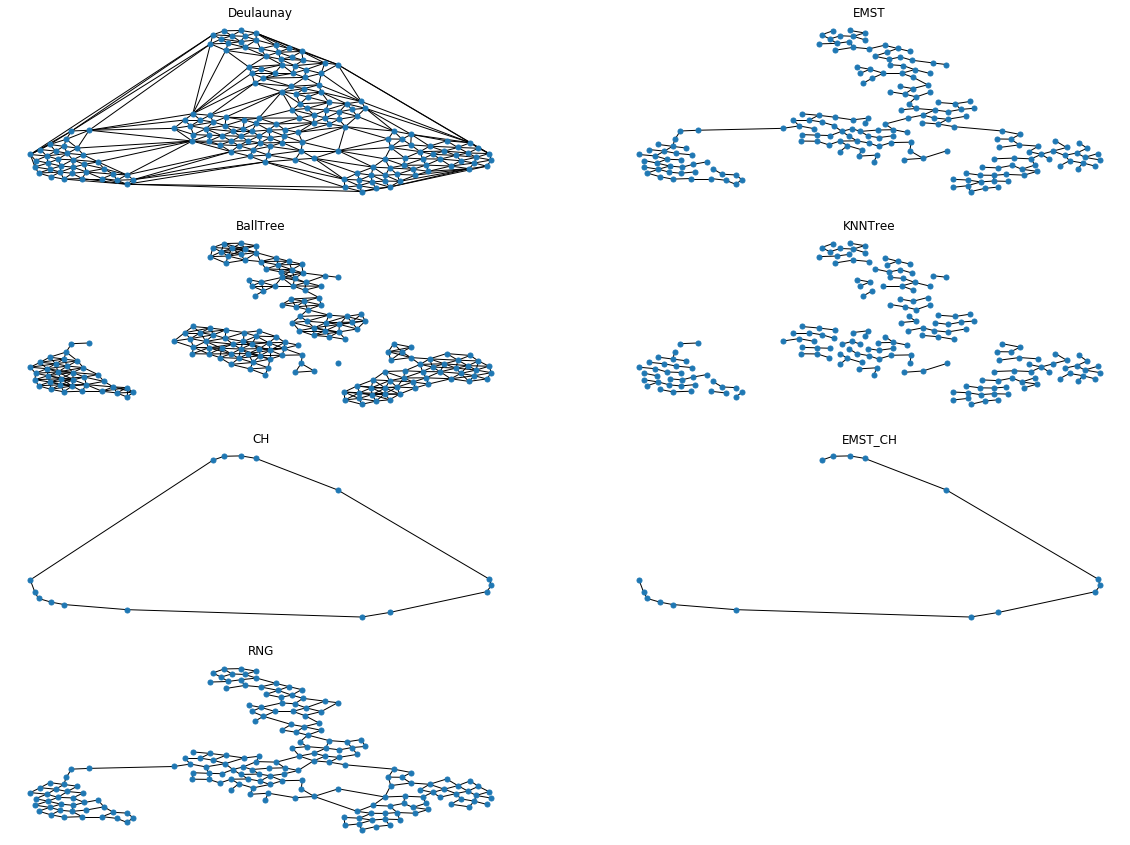

In [5]:
pointIDXY = dict(zip(range(len(df[['x','y']])), np.array(df[['x','y']])))

f = plt.figure(figsize=(20,15))

# test Delauney
graph_del = get_delaunay(df)
plt.subplot(421, figure = f, title = 'Deulaunay')
nx.draw(graph_del, pointIDXY, node_size=25)

# test EMST
graph_mst = get_mst(graph_del)
plt.subplot(422, figure = f, title = 'EMST')
nx.draw(graph_mst, pointIDXY, node_size=25)

# test BallTree
graph = get_balltree(df, 50)
plt.subplot(423, figure = f, title = 'BallTree')
nx.draw(graph, pointIDXY, node_size=25)

# test KNNtree
graph = get_knntree(df,2)
plt.subplot(424, figure = f, title = 'KNNTree')
nx.draw(graph, pointIDXY, node_size=25)

# test Convex Hull (CH)
graph_ch = get_convex_hull(df)
plt.subplot(425, figure = f, title = 'CH')
nx.draw(graph_ch, pointIDXY, node_size=25)

# test EMST from CH
graph_mst_ch = get_mst(graph_ch)
plt.subplot(426, figure = f, title = 'EMST_CH')
nx.draw(graph_mst_ch, pointIDXY, node_size=25)

# test EMST from CH
graph_mst_ch = get_rng(df, graph_del, graph_mst)
plt.subplot(427, figure = f, title = 'RNG')
nx.draw(graph_mst_ch, pointIDXY, node_size=25)







plt.show()

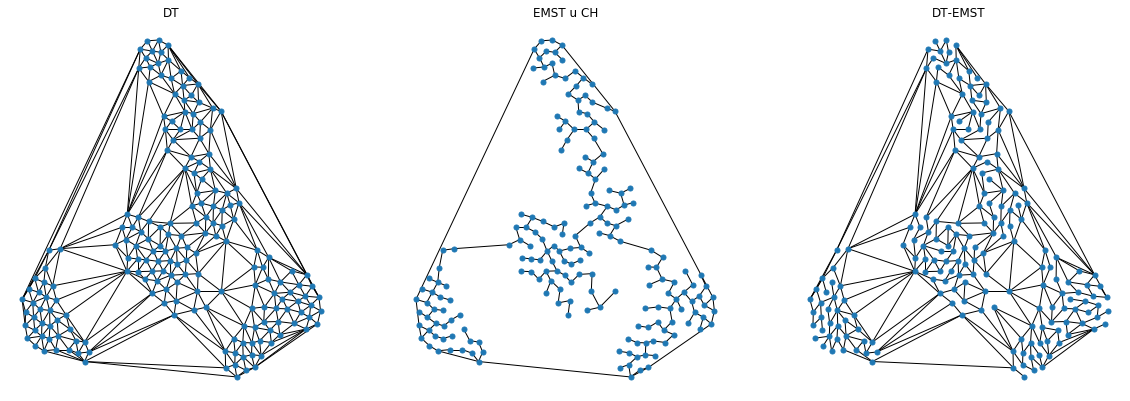

In [15]:
f = plt.figure(figsize=(20,15))

plt.subplot(231, figure = f, title = 'DT')
nx.draw(graph_del, pointIDXY, node_size=25)

mst_ch_union = nx.compose(graph_mst, graph_ch)
#print(mst_ch_union.edges(data = True))
plt.subplot(232, figure = f, title = 'EMST u CH')
nx.draw(mst_ch_union, pointIDXY, node_size=25)

candidate_graph  = nx.difference(graph_del, mst_ch_union)
#print(candidate_graph.edges(data = True))
plt.subplot(233, figure = f, title = 'DT-EMST')
nx.draw(candidate_graph, pointIDXY, node_size=25)


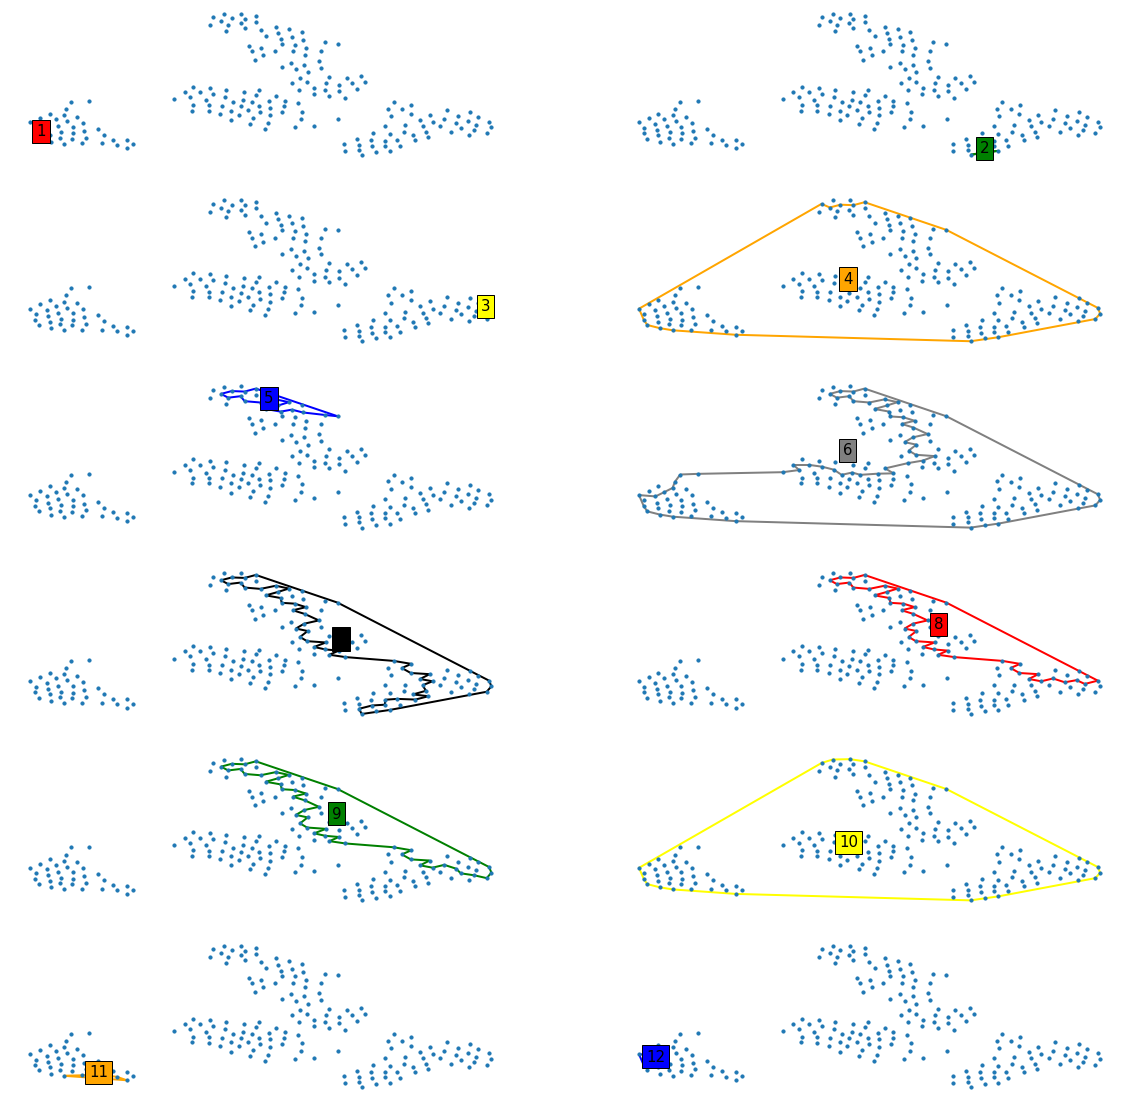

In [143]:
cycles = nx.cycle_basis(mst_ch_union)
colors = itertools.cycle(["red", "green", "yellow", 'orange','blue','gray', 'black'])

cycle_graphs = []
f = plt.figure(figsize=(20,20))

for i, cycle in enumerate(cycles):
    
    graph = nx.cycle_graph(cycle)
    graph.add_nodes_from(pointIDXY.keys())
    
    cycle_graphs.append(graph)
    plt.subplot(6,2,i+1, figure = f, title = '')
    cc = next(colors)
    nx.draw(graph, pointIDXY, node_size=10, edge_color = cc, alpha=1, width =2)
    cen = np.mean([pointIDXY.get(key) for key in cycle], axis =0)
    plt.text(cen[0],cen[1],s=str(i+1), bbox=dict(facecolor=cc, alpha=1),horizontalalignment='center', fontsize=15)
    

    
plt.show()

In [21]:
df
graph = nx.Graph()
graph.add_nodes_from([(x, df.to_dict('index')[x]) for x in df.to_dict('index')])
graph.nodes(data=True)


NodeDataView({0: {'x': 121, 'y': 289, 'class': 0}, 1: {'x': 129, 'y': 223, 'class': 0}, 2: {'x': 130, 'y': 257, 'class': 0}, 3: {'x': 135, 'y': 191, 'class': 0}, 4: {'x': 138, 'y': 315, 'class': 0}, 5: {'x': 149, 'y': 281, 'class': 0}, 6: {'x': 151, 'y': 244, 'class': 0}, 7: {'x': 154, 'y': 211, 'class': 0}, 8: {'x': 154, 'y': 342, 'class': 0}, 9: {'x': 156, 'y': 172, 'class': 0}, 10: {'x': 164, 'y': 307, 'class': 0}, 11: {'x': 168, 'y': 264, 'class': 0}, 12: {'x': 172, 'y': 196, 'class': 0}, 13: {'x': 173, 'y': 228, 'class': 0}, 14: {'x': 178, 'y': 159, 'class': 0}, 15: {'x': 178, 'y': 332, 'class': 0}, 16: {'x': 182, 'y': 369, 'class': 0}, 17: {'x': 184, 'y': 295, 'class': 0}, 18: {'x': 191, 'y': 413, 'class': 0}, 19: {'x': 192, 'y': 190, 'class': 0}, 20: {'x': 193, 'y': 261, 'class': 0}, 21: {'x': 194, 'y': 222, 'class': 0}, 22: {'x': 201, 'y': 323, 'class': 0}, 23: {'x': 209, 'y': 162, 'class': 0}, 24: {'x': 211, 'y': 287, 'class': 0}, 25: {'x': 213, 'y': 237, 'class': 0}, 26: {'x'

In [28]:
def get_kncg(df, n=2):
    X = df[['x','y']]
    A = kneighbors_graph(X, n, mode='distance', include_self=True)
    A.toarray()
    graph = nx.from_numpy_matrix(A.toarray())
    #nx.draw(graph, pointIDXY, node_size=25)
    return graph

{1: 2.1333859328655733,
 2: 1.4946627138087103,
 3: 1.4253508694297492,
 4: 1.5102809777630475}

In [50]:
X = df[['x','y']]
n = 3
A = kneighbors_graph(X, n, mode='distance', include_self=False)
A.toarray()[0]

array([ 0.        ,  0.        , 33.24154028,  0.        , 31.06444913,
       29.12043956,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [51]:
idx = np.argmax(A.toarray(), axis=1)
A[:][idx] = 0
A.toarray()[0]

/anaconda3/envs/SepMe/lib/python3.7/site-packages/scipy/sparse/_index.py:112: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


array([ 0.        ,  0.        , 33.24154028,  0.        , 31.06444913,
       29.12043956,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

array([ 0.        ,  0.        , 33.24154028,  0.        , 31.06444913,
       29.12043956,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [52]:
A.shape

(192, 192)

In [53]:
idx.shape

(192,)

In [63]:
a = np.arange(6).reshape(2,3) + 10
a


print(list(np.argmax(a, axis=1)))
a




[2, 2]


array([[10, 11, 12],
       [13, 14, 15]])

In [86]:
a[:, list(np.argmax(a, axis=1))]

array([12, 12])

In [71]:
a[np.unravel_index(np.argmax(a, axis=1), a.shape)]

array([12, 12])

In [73]:
np.unravel_index(np.argmax(a, axis=1), a.shape)

TypeError: unravel_index() missing 1 required positional argument: 'indices'

In [ ]:
pd.DataFrame()